# Multi-Layer Perceptron Regression for producing ratings

In [1]:
from sklearn.linear_model import LassoCV

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import colorsys
import math

In [3]:
data = scipy.io.loadmat('data/kulerData.mat')
hueProbs = scipy.io.loadmat('data/hueProbsRGB.mat')
huedata = hueProbs['hueProbs']

In [4]:
palette = data['data']
rating = data['targets']

In [5]:
hueProb  = huedata['hueProb']
hueJoint = huedata['hueJoint']
hueAdjacency = huedata['hueAdjacency']
hueSaturation = huedata['hueSaturation']
hueValue = huedata['hueValue']
hueJointRating = huedata['hueJointRating']
hueAdjacencyRating = huedata['hueAdjacencyRating']
hueSaturationRating = huedata['hueSaturationRating']
hueValueRating = huedata['hueValueRating']
hueRatingFactor = huedata['hueRatingFactor']

In [6]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

D:\Python\ANaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
def rgb2hsv(r, g, b):
    h, s, v, = colorsys.rgb_to_hsv(r, g, b)
    return h, s, v

In [8]:
def rgb2chsv(r, g, b):
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    d1 = s*math.cos(h)
    d2 = s*math.sin(h)
    d3 = v
    return d1, d2, d3

In [9]:
def rgb2lab(r, g, b):
    inputColor = [r, g, b]
    num = 0
    RGB = [0, 0, 0]
    for value in inputColor:
        value = float(value) / 255
        if value > 0.04045:
            value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
        else:
            value = value / 12.92
        RGB[num] = value * 100
        num = num + 1
    XYZ = [0, 0, 0,]
    X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
    Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
    Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
    XYZ[ 0 ] = round( X, 4 )
    XYZ[ 1 ] = round( Y, 4 )
    XYZ[ 2 ] = round( Z, 4 )
    XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
    XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
    XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883
    num = 0
    for value in XYZ:
        if value > 0.008856:
            value = value ** ( 0.3333333333333333 )
        else:
            value = ( 7.787 * value ) + ( 16 / 116 )
        XYZ[num] = value
        num = num + 1
    Lab = [0, 0, 0]
    L = ( 116 * XYZ[ 1 ] ) - 16
    a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
    b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )
    Lab [ 0 ] = round( L, 4 )
    Lab [ 1 ] = round( a, 4 )
    Lab [ 2 ] = round( b, 4 )
    return Lab[0], Lab[1], Lab[2]

In [10]:
def find_dif(col1, col2):
    d1 = abs(col1[0] - col2[0])
    d2 = abs(col1[1] - col2[2])
    d3 = abs(col1[0] - col2[0])
    return d1, d2, d3

In [22]:
def create_features(palette, hueProb, hueJoint, hueAdjacency):
    rgb = np.zeros((len(palette), 3))
    lab = np.zeros((len(palette), 3))
    hsv = np.zeros((len(palette), 3))
    chsv = np.zeros((len(palette), 3))
    rgb_sorted = np.zeros((len(palette), 3))
    lab_sorted = np.zeros((len(palette), 3))
    hsv_sorted = np.zeros((len(palette), 3))
    chsv_sorted = np.zeros((len(palette), 3))
    rgb_diff = np.zeros((4, 3))
    lab_diff = np.zeros((4, 3))
    hsv_diff = np.zeros((4, 3))
    chsv_diff = np.zeros((4, 3))
    rgb_diff_s = np.zeros((4, 3))
    lab_diff_s = np.zeros((4, 3))
    hsv_diff_s = np.zeros((4, 3))
    chsv_diff_s = np.zeros((4, 3))
    rgb_mean = np.zeros(3)
    rgb_std = np.zeros(3)
    rgb_median = np.zeros(3)
    rgb_min = np.zeros(3)
    rgb_max = np.zeros(3)
    lab_mean = np.zeros(3)
    lab_std = np.zeros(3)
    lab_median = np.zeros(3)
    lab_min = np.zeros(3)
    lab_max = np.zeros(3)
    hsv_mean = np.zeros(3)
    hsv_std = np.zeros(3)
    hsv_median = np.zeros(3)
    hsv_min = np.zeros(3)
    hsv_max = np.zeros(3)
    chsv_mean = np.zeros(3)
    chsv_std = np.zeros(3)
    chsv_median = np.zeros(3)
    chsv_min = np.zeros(3)
    chsv_max = np.zeros(3)
    rgb_mmd = np.zeros(3)
    lab_mmd = np.zeros(3)
    hsv_mmd = np.zeros(3)
    chsv_mmd = np.zeros(3)
    hj = np.zeros((5, 5))
    ha = np.zeros((5, 5))
    for i in range(len(palette)):
        rgb[i] = palette[i]
        lab[i] = rgb2lab(rgb[i][0], rgb[i][1], rgb[i][2])
        hsv[i] = rgb2hsv(rgb[i][0], rgb[i][1], rgb[i][2])
        chsv[i] = rgb2chsv(rgb[i][0], rgb[i][1], rgb[i][2]) 
        rgb_sorted[i] = sorted(rgb[i])
        lab_sorted[i] = sorted(lab[i])
        hsv_sorted[i] = sorted(hsv[i])
        chsv_sorted[i] = sorted(chsv[i])
    for i in range(4):
        rgb_diff[i] = find_dif(rgb[i], rgb[i+1])
        lab_diff[i] = find_dif(lab[i], lab[i+1])
        hsv_diff[i] = find_dif(hsv[i], hsv[i+1])
        chsv_diff[i] = find_dif(chsv[i], chsv[i+1])
        rgb_diff_s[i] = sorted(rgb_diff[i])
        lab_diff_s[i] = sorted(lab_diff[i])
        hsv_diff_s[i] = sorted(hsv_diff[i])
        chsv_diff_s[i] = sorted(chsv_diff[i])
    for i in range(3):
        rgb_mean[i] = np.mean(rgb[:, i])
        rgb_std[i] = np.std(rgb[:, i])
        rgb_median[i] = np.median(rgb[:, i])
        rgb_min[i] = min(rgb[:, i])
        rgb_max[i] = max(rgb[:, i])
        lab_mean[i] = np.mean(lab[:, i])
        lab_std[i] = np.std(lab[:, i])
        lab_median[i] = np.median(lab[:, i])
        lab_min[i] = min(lab[:, i])
        lab_max[i] = max(lab[:, i])
        hsv_mean[i] = np.mean(hsv[:, i])
        hsv_std[i] = np.std(hsv[:, i])
        hsv_median[i] = np.median(hsv[:, i])
        hsv_min[i] = min(hsv[:, i])
        hsv_max[i] = max(hsv[:, i])
        chsv_mean[i] = np.mean(chsv[:, i])
        chsv_std[i] = np.std(chsv[:, i])
        chsv_median[i] = np.median(chsv[:, i])
        chsv_min[i] = min(chsv[:, i])
        chsv_max[i] = max(chsv[:, i])
        rgb_mmd[i] = rgb_max[i] - rgb_min[i]
        lab_mmd[i] = lab_max[i] - lab_min[i]
        hsv_mmd[i] = hsv_max[i] - hsv_min[i]
        chsv_mmd[i] = chsv_max[i] - chsv_min[i]
        
    hsv_indices = (hsv[:, 0]*360).astype(int)
    hp_mean = np.mean(hueProb[0][0][hsv_indices]/100.0)
    hp_std = np.std(hueProb[0][0][hsv_indices]/100.0)
    hp_min = np.amin(hueProb[0][0][hsv_indices]/100.0)
    hp_max = np.amax(hueProb[0][0][hsv_indices]/100.0)
    hp_mean_log = np.mean(np.log(hueProb[0][0][hsv_indices]/100.0))
    hp_std_log = np.std(np.log(hueProb[0][0][hsv_indices]/100.0))
    hp_min_log = np.amin(np.log(hueProb[0][0][hsv_indices]/100.0))
    hp_max_log = np.amax(np.log(hueProb[0][0][hsv_indices]/100.0))
    
    for i in range(5):
        for j in range(5):
            hj[i][j] = hueJoint[0][0][hsv_indices[i]][hsv_indices[j]]
            ha[i][j] = hueAdjacency[0][0][hsv_indices[i]][hsv_indices[j]]
            
    hj_mean = np.mean(hj/100.0)
    hj_std = np.std(hj/100.0)
    hj_min = np.min(hj/100.0)
    hj_max = np.max(hj/100.0)
    hj_mean_log = np.mean(np.log((hj/100.0)))
    hj_std_log = np.std(np.log((hj/100.0)))
    hj_min_log = np.min(np.log((hj/100.0)))
    hj_max_log = np.max(np.log((hj/100.0)))
    
    
    ha_mean = np.mean(ha/100.0)
    ha_std = np.std(ha/100.0)
    ha_min = np.min(ha/100.0)
    ha_max = np.max(ha/100.0)
    ha_mean_log = np.mean(np.log((ha/100.0)))
    ha_std_log = np.std(np.log((ha/100.0)))
    ha_min_log = np.min(np.log((ha/100.0)))
    ha_max_log = np.max(np.log((ha/100.0)))

    result = (np.ravel(rgb), np.ravel(rgb_sorted), np.ravel(rgb_diff), np.ravel(rgb_diff_s), np.ravel(rgb_mean),np.ravel(rgb_std), np.ravel(rgb_median), np.ravel(rgb_max), np.ravel(rgb_min), np.ravel(rgb_mmd), np.ravel(lab), np.ravel(lab_sorted), np.ravel(lab_diff), np.ravel(lab_diff_s), np.ravel(lab_mean),np.ravel(lab_std), np.ravel(lab_median), np.ravel(lab_max), np.ravel(lab_min), np.ravel(lab_mmd), np.ravel(chsv), np.ravel(chsv_sorted), np.ravel(chsv_diff), np.ravel(chsv_diff_s), np.ravel(chsv_mean),np.ravel(chsv_std), np.ravel(chsv_median), np.ravel(chsv_max), np.ravel(chsv_min), np.ravel(chsv_mmd), np.ravel(hsv), np.ravel(hsv_sorted), np.ravel(hsv_diff), np.ravel(hsv_diff_s), np.ravel(hsv_mean),np.ravel(hsv_std), np.ravel(hsv_median), np.ravel(hsv_max), np.ravel(hsv_min), np.ravel(hsv_mmd), np.ravel(hp_mean), np.ravel(hp_std), np.ravel(hp_max), np.ravel(hp_min), np.ravel(hp_mean_log), np.ravel(hp_std_log), np.ravel(hp_max_log), np.ravel(hp_min_log), np.ravel(ha_mean), np.ravel(ha_std), np.ravel(ha_max), np.ravel(ha_min), np.ravel(ha_mean_log), np.ravel(ha_std_log), np.ravel(ha_max_log), np.ravel(ha_min_log), np.ravel(hj_mean), np.ravel(hj_std), np.ravel(hj_max), np.ravel(hj_min), np.ravel(hj_mean_log), np.ravel(hj_std_log), np.ravel(hj_max_log), np.ravel(hj_min_log))
    r = np.concatenate(result).ravel()
    #result = np.ndarray.flatten(np.array(np.ravel(rgb), np.ravel(rgb_sorted), np.ravel(rgb_diff), np.ravel(rgb_diff_s), np.ravel(rgb_mean), np.ravel(rgb_std), np.ravel(rgb_median), np.ravel(rgb_min), np.ravel(rgb_max), np.ravel(rgb_mmd))
    #r = np.ravel(result)
    #print (len(r))
    return r
    
    #print((hueJoint[0][0][(hsv[:, 0]*360).astype(int)]/100.0))
    #print((hueJoint[0][0][(hsv[:, 0]*360).astype(int)][np.transpose((hsv[:, 0]*360).astype(int))])

In [258]:
#create_features(palette[0], hueProb, hueJoint, hueAdjacency)

In [24]:
w = len(palette)
h = 312
features = np.zeros((w, h))

In [33]:
for i in range(w):
    features[i] = create_features(palette[i], hueProb, hueJoint, hueAdjacency)
    if(i%1000 == 0):
        print (int(i/1000.0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


Check whether there are NaNs and inf-s in data and replace them with 0:

In [98]:
features_clean = features
features_clean[np.isnan(features_clean)] = 0
features_clean[np.isinf(features_clean)] = 0

In [99]:
print(np.any(np.isnan(features_clean)))
print(np.all(np.isfinite(features_clean)))

False
True


In [100]:
ratings_clean = rating
ratings_clean[np.isnan(ratings_clean)] = 0
ratings_clean[np.isinf(ratings_clean)] = 0

In [101]:
print(np.any(np.isnan(ratings_clean)))
print(np.all(np.isfinite(ratings_clean)))

False
True


Prepare train and test data:

In [270]:
X = features_clean
Y = ratings_clean

In [271]:
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)

MLPClassifier:

In [272]:
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import cross_val_predict
from sklearn import cross_validation

In [273]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(activation='logistic')

In [274]:
mlp.fit(X_train,y_train)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [275]:
predictions = mlp.predict(X_test)

In [276]:
rmse = np.sqrt(mean_squared_error(y_test,predictions))
rmse

0.66908332879296017

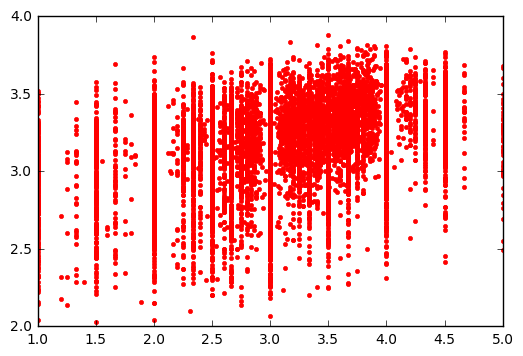

In [277]:
plt.plot(y_test, predictions, 'r.')
plt.show()